In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix


In [2]:
path_to_query_adata = "/mnt/sata2/Analysis_Alex_2/perturb4_no_baysor/final_object_corrected.h5ad"
query_adata = sc.read(path_to_query_adata)

In [3]:
import sys
sys.path.insert(0, '/home/amonell/piloting/scvi-tools/src')
print("Added to path:", sys.path[0])

import scvi.external.resolvi as RESOLVI
import scvi
print("Importing from:", scvi.external.resolvi.__file__)

Added to path: /home/amonell/piloting/scvi-tools/src
Importing from: /home/amonell/piloting/scvi-tools/src/scvi/external/resolvi/__init__.py


In [4]:
#sc.pp.subsample(query_adata, fraction=0.1)

In [5]:
#query_adata = query_adata[query_adata.obs['guide_rnas'].isin(['Other cells', 'sgCxcr3', 'sgCd19'])]

In [5]:

RESOLVI.RESOLVI.setup_anndata(
    query_adata, 
    labels_key="cell_types",
    layer="raw",
    batch_key="batch", 
    perturbation_key="guide_rnas", 
    control_perturbation="sgCd19",
    background_key="guide_rnas",
    background_category="Other cells"
)

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [ ]:
supervised_resolvi = RESOLVI.RESOLVI(
    query_adata, semisupervised=True, mixture_k = 1, n_latent = 32, perturbation_hidden_dim=128, override_mixture_k_in_semisupervised=False
)

# supervised_resolvi = RESOLVI.RESOLVI(
#     query_adata, semisupervised=True, mixture_k = 13,
#      n_latent=50,              # Higher latent dims
#     n_hidden=128,             # Increase from 32 (decoder)
#     n_hidden_encoder=256,     # Increase from 128 (encoder) 
#    override_mixture_k_in_semisupervised=False
#)

In [7]:


priors = supervised_resolvi.compute_dataset_dependent_priors()
print(priors)


{'background_ratio': 0.00067531277, 'median_distance': 372.9849853515625, 'mean_log_counts': 5.433722, 'std_log_counts': 0.8109416}


In [13]:
supervised_resolvi.module.guide.downsample_counts_mean = float(
    supervised_resolvi.module.guide.downsample_counts_mean
)
supervised_resolvi.module.guide.downsample_counts_std = float(
    supervised_resolvi.module.guide.downsample_counts_std
)
supervised_resolvi.train(
    max_epochs=200,
    check_val_every_n_epoch=100,
    lr=3e-4,
    train_on_perturbed_only=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training configuration with train_on_perturbed_only=True:
  Training set: 2465 perturbation-relevant cells (0.3%)
    - Control cells: 454 (0.1%)
    - Perturbed cells: 2011 (0.2%)
  Excluded from training: 807760 background cells (99.7%)
  Background/neighbor computations: all 810225 cells


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
supervised_resolvi.save('perturb_model.model')

In [18]:
query_adata.write('perturb_model.model/query_adata.h5ad')

In [11]:
query_adata =  sc.read('perturb_model.model/query_adata.h5ad')

In [12]:
supervised_resolvi = RESOLVI.RESOLVI.load('perturb_model.model',query_adata)

INFO     File perturb_model.model/model.pt already downloaded                                                      


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 2341 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


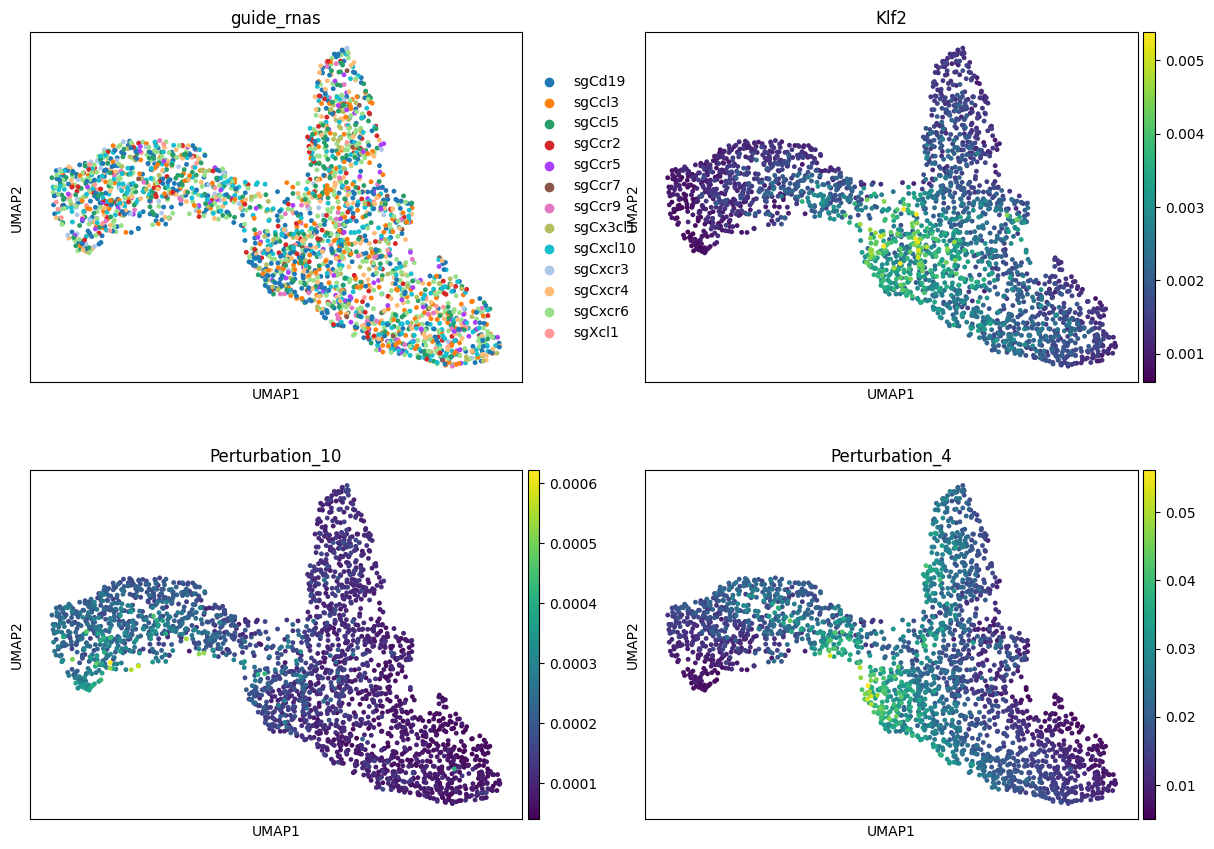

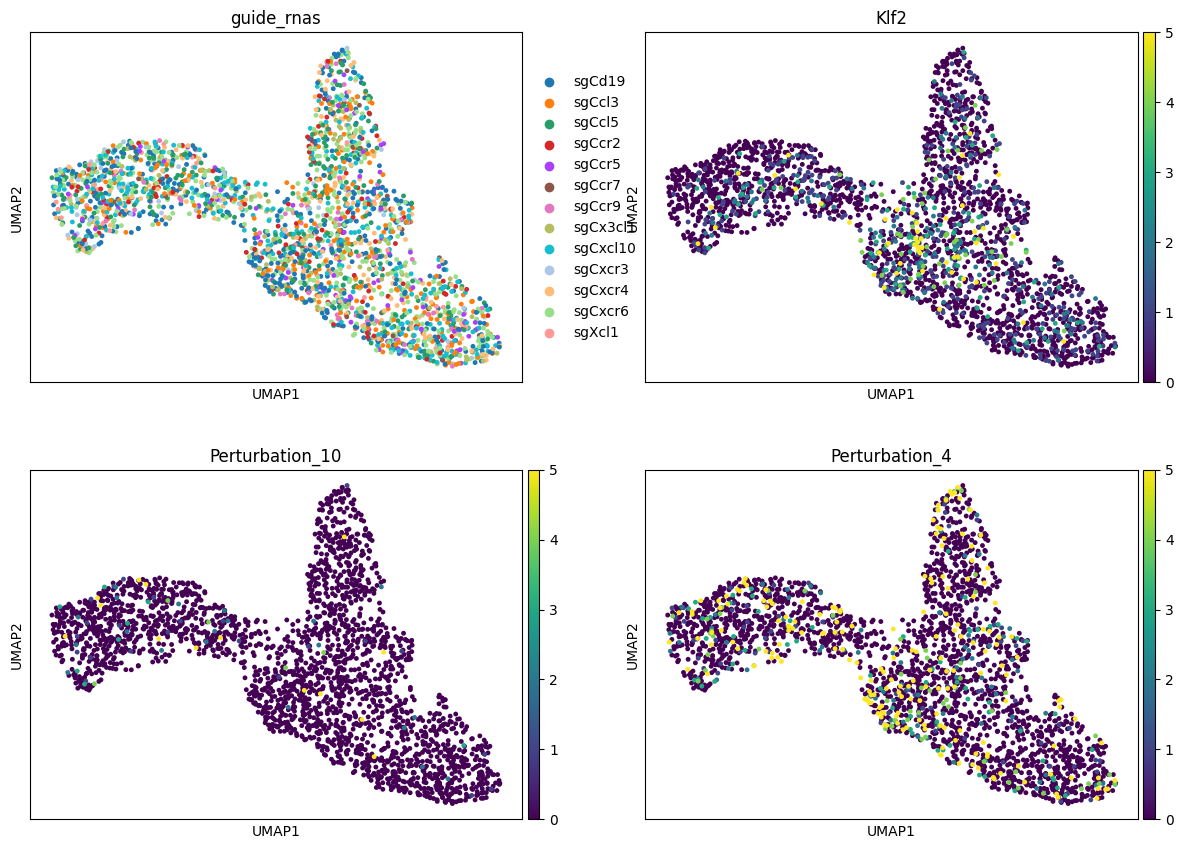

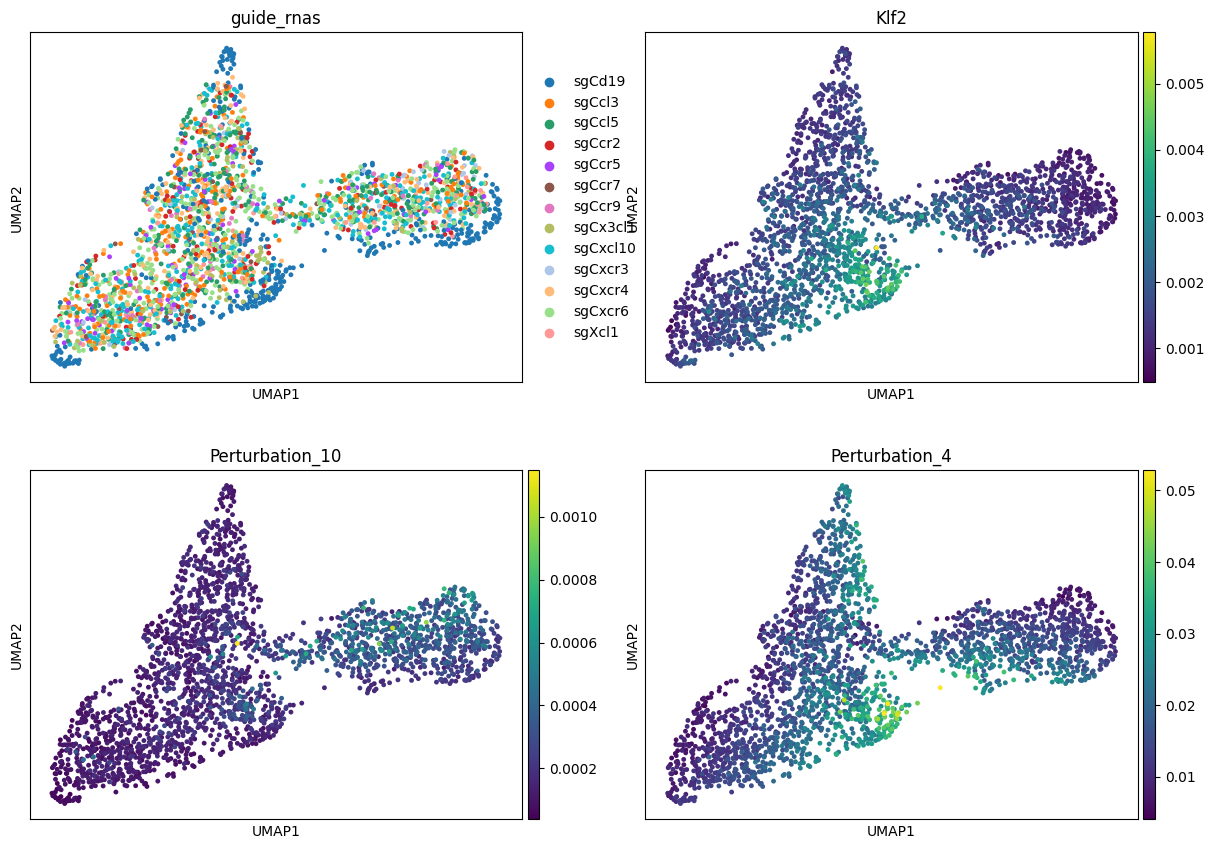

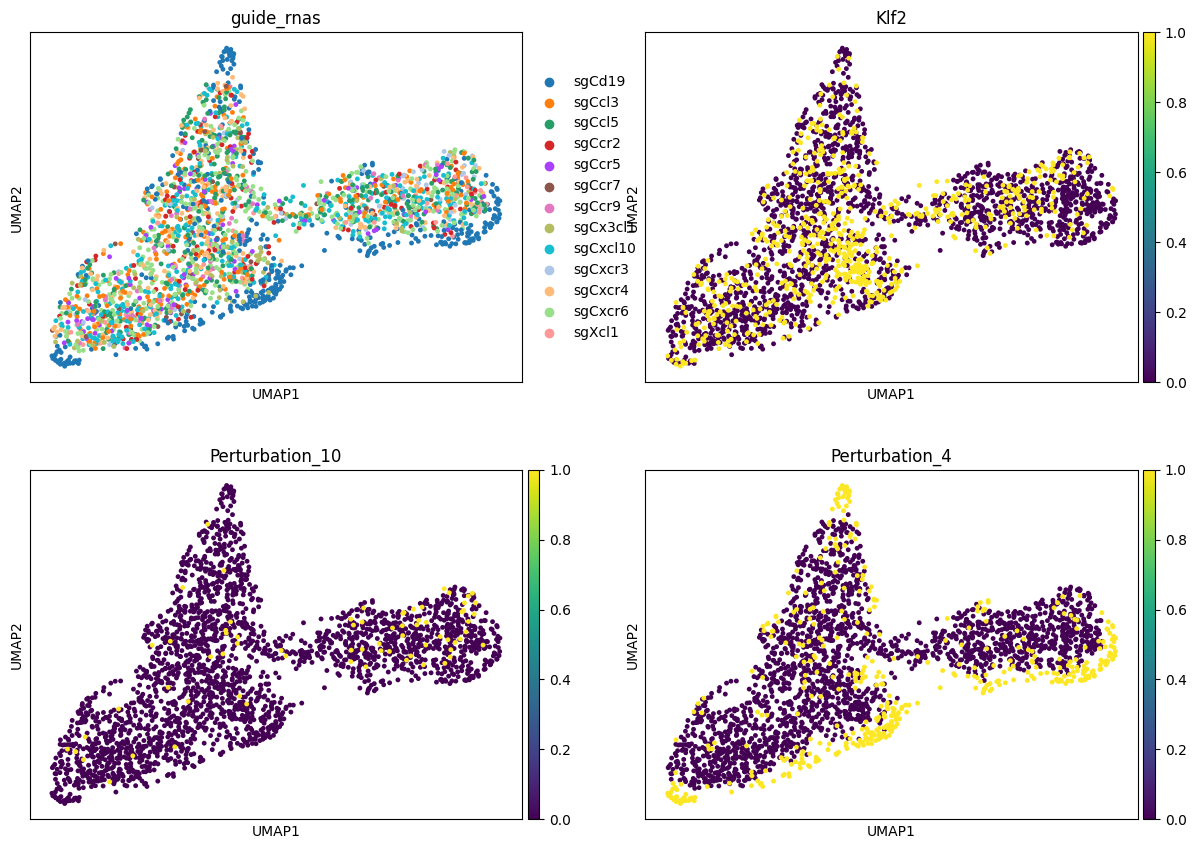

In [14]:
mini_adata = query_adata[query_adata.obs['guide_rnas'] != 'Other cells']
# Get denoised expression assuming control (no perturbations)
control_expr = supervised_resolvi.get_denoised_expression_control(mini_adata)

mini_adata.layers['resolvi_expression_no_shift'] = control_expr.values

sc.tl.pca(mini_adata, layer='resolvi_expression_no_shift')
sc.pp.neighbors(mini_adata)
sc.tl.umap(mini_adata)
sc.pl.umap(mini_adata, color=['guide_rnas', 'Klf2', 'Perturbation_10', 'Perturbation_4'], layer='resolvi_expression_no_shift', ncols=2)
sc.pl.umap(mini_adata, color=['guide_rnas', 'Klf2', 'Perturbation_10', 'Perturbation_4'], ncols=2, vmax=5)

perturbed_expr = supervised_resolvi.get_denoised_expression_perturbed(mini_adata)

mini_adata.layers['resolvi_expression_with_shift'] = perturbed_expr.values

sc.tl.pca(mini_adata, layer='resolvi_expression_with_shift')
sc.pp.neighbors(mini_adata)
sc.tl.umap(mini_adata)
sc.pl.umap(mini_adata, color=['guide_rnas', 'Klf2', 'Perturbation_10', 'Perturbation_4'], layer='resolvi_expression_with_shift', ncols=2)
sc.pl.umap(mini_adata, color=['guide_rnas', 'Klf2', 'Perturbation_10', 'Perturbation_4'], ncols=2, vmax=1)




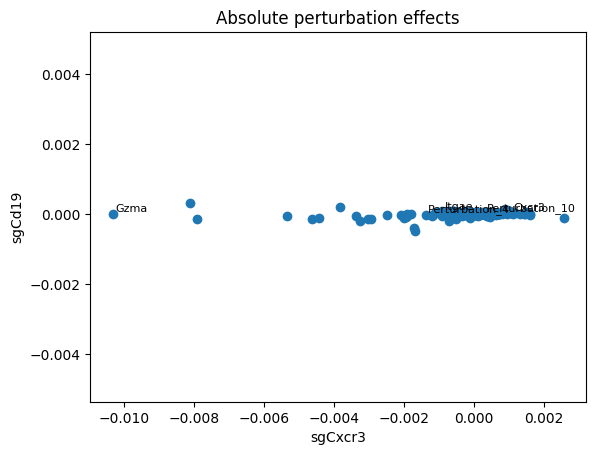

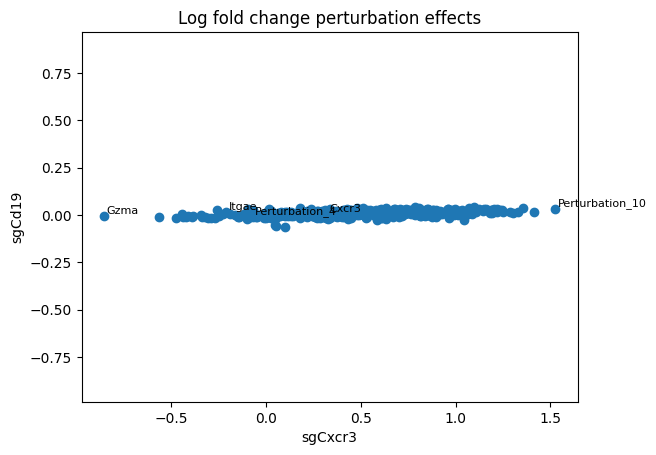

In [15]:

mini_adata.layers['absolute_perturbation_effects'] = perturbed_expr - control_expr

log_fold_change = np.log2(perturbed_expr + 1e-8) - np.log2(control_expr + 1e-8)

batch1_counts = mini_adata[mini_adata.obs['guide_rnas'] == 'sgCxcr3'].layers['absolute_perturbation_effects'].mean(axis=0)
batch2_counts = mini_adata[mini_adata.obs['guide_rnas'] == 'sgCd19'].layers['absolute_perturbation_effects'].mean(axis=0)
plt.scatter(batch1_counts, batch2_counts)
plt.axis('equal')
# Annotate specific points only
genes_to_annotate = ['Cxcr3', 'Gzma', 'Itgae', 'Perturbation_10', 'Perturbation_4']
for i, gene_name in enumerate(mini_adata.var.index):
    if gene_name in genes_to_annotate:
        plt.annotate(gene_name, (batch1_counts[i], batch2_counts[i]), 
                    textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('sgCxcr3')
plt.ylabel('sgCd19')
plt.title('Absolute perturbation effects')
plt.show()

mini_adata.layers['log_fold_change'] = log_fold_change
batch1_counts = mini_adata[mini_adata.obs['guide_rnas'] == 'sgCxcr3'].layers['log_fold_change'].mean(axis=0)
batch2_counts = mini_adata[mini_adata.obs['guide_rnas'] == 'sgCd19'].layers['log_fold_change'].mean(axis=0)
plt.scatter(batch1_counts, batch2_counts)
plt.axis('equal')
# Annotate specific points only
genes_to_annotate = ['Cxcr3', 'Gzma', 'Itgae', 'Perturbation_10', 'Perturbation_4']
for i, gene_name in enumerate(mini_adata.var.index):
    if gene_name in genes_to_annotate:
        plt.annotate(gene_name, (batch1_counts[i], batch2_counts[i]), 
                    textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('sgCxcr3')
plt.ylabel('sgCd19')
plt.title('Log fold change perturbation effects')
plt.show()

/tmp/ipykernel_3144759/3065927883.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(gene_name, (sgCxcr3_mean_expr[i], sgCxcr3_absolute[i]),
/tmp/ipykernel_3144759/3065927883.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(gene_name, (sgCxcr3_mean_expr[i], sgCxcr3_lfc[i]),


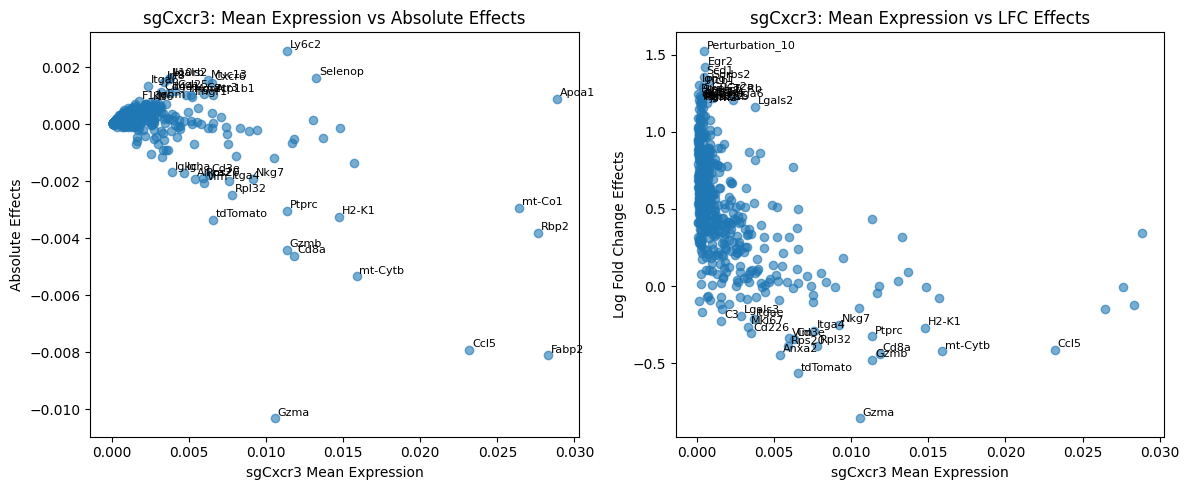

In [17]:
# Get sgCxcr3 mean expression from perturbed_expr
sgCxcr3_mean_expr = perturbed_expr[mini_adata.obs['guide_rnas'] == 'sgCxcr3'].mean(axis=0)

# Calculate absolute and log fold change effects
absolute_effects = perturbed_expr - control_expr
log_fold_change = np.log2(perturbed_expr + 1e-8) - np.log2(control_expr + 1e-8)

# Get sgCxcr3 effects
sgCxcr3_absolute = absolute_effects[mini_adata.obs['guide_rnas'] == 'sgCxcr3'].mean(axis=0)
sgCxcr3_lfc = log_fold_change[mini_adata.obs['guide_rnas'] == 'sgCxcr3'].mean(axis=0)

# Plot absolute effects vs mean expression
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(sgCxcr3_mean_expr, sgCxcr3_absolute, alpha=0.6)

# Get top and bottom points for absolute effects
abs_top_indices = np.argsort(sgCxcr3_absolute)[-20:]  # Top 5
abs_bottom_indices = np.argsort(sgCxcr3_absolute)[:20]  # Bottom 5
abs_annotate_indices = np.concatenate([abs_top_indices, abs_bottom_indices])

for i in abs_annotate_indices:
    gene_name = mini_adata.var.index[i]
    plt.annotate(gene_name, (sgCxcr3_mean_expr[i], sgCxcr3_absolute[i]), 
                textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('sgCxcr3 Mean Expression')
plt.ylabel('Absolute Effects')
plt.title('sgCxcr3: Mean Expression vs Absolute Effects')

# Plot log fold change effects vs mean expression
plt.subplot(1, 2, 2)
plt.scatter(sgCxcr3_mean_expr, sgCxcr3_lfc, alpha=0.6)

# Get top and bottom points for log fold change
lfc_top_indices = np.argsort(sgCxcr3_lfc)[-20:]  # Top 5
lfc_bottom_indices = np.argsort(sgCxcr3_lfc)[:20]  # Bottom 5
lfc_annotate_indices = np.concatenate([lfc_top_indices, lfc_bottom_indices])

for i in lfc_annotate_indices:
    gene_name = mini_adata.var.index[i]
    plt.annotate(gene_name, (sgCxcr3_mean_expr[i], sgCxcr3_lfc[i]), 
                textcoords="offset points", xytext=(2,2), ha='left', fontsize=8)
plt.xlabel('sgCxcr3 Mean Expression')
plt.ylabel('Log Fold Change Effects')
plt.title('sgCxcr3: Mean Expression vs LFC Effects')

plt.tight_layout()
plt.show()

In [18]:
sgCxcr3_lfc.loc[['Cxcr3', 'Itgae', 'Mki67', 'Klf2', 'Gzma']]

Cxcr3    0.318558
Itgae   -0.211885
Mki67   -0.261817
Klf2     0.019853
Gzma    -0.855512
dtype: float32

In [ ]:

from scipy.stats import spearmanr
import numpy as np

perturbation_effects = effects_cells.loc['sgCxcr3'].values
# Calculate the difference in gene counts between the two batches
batch1_counts = query_adata[query_adata.obs['guide_rnas'] == 'sgCxcr3'].layers['resolvi_expression'].mean(axis=0)
batch2_counts = query_adata[query_adata.obs['guide_rnas'] == 'sgCd19'].layers['resolvi_expression'].mean(axis=0)
gene_count_diff = batch1_counts - batch2_counts

# Filter perturbation effects where values are less than 0.05
valid_indices = np.abs(perturbation_effects) >= 0
gene_count_diff_filtered = gene_count_diff[valid_indices]
perturbation_effects_filtered = perturbation_effects[valid_indices]

# Get gene names for annotation
gene_names = query_adata.var.index.values if hasattr(query_adata.var, "index") else np.arange(len(perturbation_effects))
gene_names_filtered = gene_names[valid_indices]

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(gene_count_diff_filtered, perturbation_effects_filtered)

# Plot the perturbation effects against the gene count differences
plt.figure(figsize=(10, 6))
plt.scatter(gene_count_diff_filtered, perturbation_effects_filtered, color='purple', alpha=0.7)

# Annotate each point with the gene name
for i, gene_name in enumerate(gene_names_filtered):
    plt.annotate(gene_name,
                 (gene_count_diff_filtered[i], perturbation_effects_filtered[i]),
                 textcoords="offset points", xytext=(5,2), ha='left', fontsize=8, color='black')

# Add line of best fit
m, b = np.polyfit(gene_count_diff_filtered, perturbation_effects_filtered, 1)
plt.plot(gene_count_diff_filtered, m * gene_count_diff_filtered + b, color='red', linestyle='--')

plt.xlabel('Difference in Gene Counts (sgCxcr3 vs sgCd19)')
plt.ylabel('Perturbation Effects')
plt.title(f'Perturbation Effects vs Gene Count Differences\nSpearman Correlation: {spearman_corr:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:


# Get denoised expression with actual perturbation effects
perturbed_expr = model.get_denoised_expression_perturbed(adata)

# Compare to see perturbation effects
perturbation_effect = np.log2(perturbed_expr + 1e-8) - np.log2(control_expr + 1e-8)

In [11]:
celltype = 'CD8 T Cells'

In [12]:
cell_indices = np.where(query_adata.obs['guide_rnas'] == 'sgCd19')[0]

In [13]:
effects_cells = supervised_resolvi.get_perturbation_effects(indices=cell_indices, n_samples=200)

Processing 4 batches (≈14 perturbations × 200 samples each):   0%|          | 0/4 [00:00<?, ?it/s]

Batch 1/4: Running 13 perturbations (200 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Batch 2/4: Running 13 perturbations (200 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Batch 3/4: Running 13 perturbations (200 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Batch 4/4: Running 13 perturbations (200 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame(list(zip(query_adata.obs['guide_rnas'].values, query_adata.obsm['_scvi_extra_categorical_covs']['guide_rnas'].values)), columns = ['celltype', 'perturb_number'])
celltype_to_perturb_number = dict(zip(df['perturb_number'], df['celltype']))

celltype_to_perturb_number = {f'perturbation_{k}': v for k, v in celltype_to_perturb_number.items()}


In [15]:
effects_cells.index = effects_cells.index.map(celltype_to_perturb_number)

In [16]:
effects_cells[['Perturbation_0', 'Perturbation_1', 'Perturbation_2', 'Perturbation_3', 'Perturbation_4', 'Perturbation_5', 'Perturbation_6', 'Perturbation_7', 'Perturbation_8', 'Perturbation_9','Perturbation_10', 'Perturbation_11', 'Perturbation_12']]

,Perturbation_0,Perturbation_1,Perturbation_2,Perturbation_3,Perturbation_4,Perturbation_5,Perturbation_6,Perturbation_7,Perturbation_8,Perturbation_9,Perturbation_10,Perturbation_11,Perturbation_12
sgCcl3,0.128911,5.184060,4.839728,-1.228966,-5.486918,0.573318,1.990913,-1.386021,-2.860262,1.508055,0.368695,1.488948,0.716261
sgCcl5,-1.565337,1.409828,3.305895,0.336581,-4.567605,4.877480,1.444825,-1.605890,-2.310777,1.436454,0.387766,2.086277,-0.818960
sgCcr2,1.326930,-0.610746,1.418437,0.016773,-4.427304,-1.622328,0.791239,3.979565,0.699163,0.217205,1.150537,-0.052759,2.770432
sgCcr5,1.948372,1.021989,3.614792,-1.176516,-6.610707,-0.452531,6.012202,-1.772532,-2.124159,0.452237,0.357515,1.351053,1.166774
sgCcr7,-1.494790,2.070110,3.419259,0.986491,-4.533349,1.801808,2.485438,-1.369812,-1.612167,1.567325,0.713541,2.625877,0.151789
sgCcr9,2.427351,-1.248889,0.237909,0.186852,-4.248916,-2.110464,0.185468,0.949788,3.589733,-0.444708,-0.406615,-0.816411,4.081594
sgCd19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sgCx3cl1,-1.920173,-0.180665,0.828790,5.017161,-3.739521,1.174139,0.625681,0.231486,0.659173,1.419269,1.374704,0.863873,1.442589
sgCxcl10,5.989224,0.191991,1.216441,-2.149782,-4.929656,-2.189770,2.157230,0.163742,0.872258,-0.479550,0.043276,-0.450626,2.636932
sgCxcr3,1.134158,0.821643,2.254699,0.730229,-4.596723,-0.519020,1.058960,1.714566,-0.768464,1.201490,1.807961,0.857150,1.744599


In [17]:

effects_cells[['Cxcr3', 'Ccr5', 'Ccl5', 'Ccr7', 'Cxcr4', 'Ccl3', 'Cxcr6', 'Xcl1']]

,Cxcr3,Ccr5,Ccl5,Ccr7,Cxcr4,Ccl3,Cxcr6,Xcl1
sgCcl3,0.006315,0.083023,0.003570,1.306086,0.153225,-0.341597,0.202740,-0.207184
sgCcl5,-0.062107,0.206013,-1.534992,0.554758,0.495196,-0.008953,0.024282,-0.416419
sgCcr2,-0.112305,0.110636,-0.003733,0.283278,-0.551640,-0.304487,-0.088455,0.415651
sgCcr5,-0.079172,-0.308556,-0.244452,0.837666,-0.472084,-0.367504,-0.002653,0.070599
sgCcr7,0.000039,0.086959,-0.179049,0.802682,-0.136543,0.195361,0.002948,-0.040790
sgCcr9,0.018280,-0.018352,-0.212036,-0.134788,-0.602462,-0.433642,-0.073452,0.351107
sgCd19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sgCx3cl1,-0.072418,-0.014850,-0.079622,-0.268425,0.189182,0.062947,0.104778,-0.213542
sgCxcl10,-0.261822,-0.213243,0.057185,0.885831,-0.659815,-0.614620,0.040357,0.345033
sgCxcr3,-0.329785,-0.010934,0.272229,0.223830,-0.028459,-0.322087,-0.026229,0.670551


In [18]:

effects_cells[['Itgae', 'Gzma', 'Tcf7', 'Cxcr3', 'Id3', 'Klrg1', 'Klf2']].loc[['sgCxcr3', 'sgCd19']]

,Itgae,Gzma,Tcf7,Cxcr3,Id3,Klrg1,Klf2
sgCxcr3,0.136758,0.606797,-0.582428,-0.329785,0.437249,0.081288,0.221624
sgCd19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
corrected_expression = supervised_resolvi.get_normalized_expression(
    adata=query_adata
)


In [20]:
query_adata.layers['resolvi_expression'] = corrected_expression

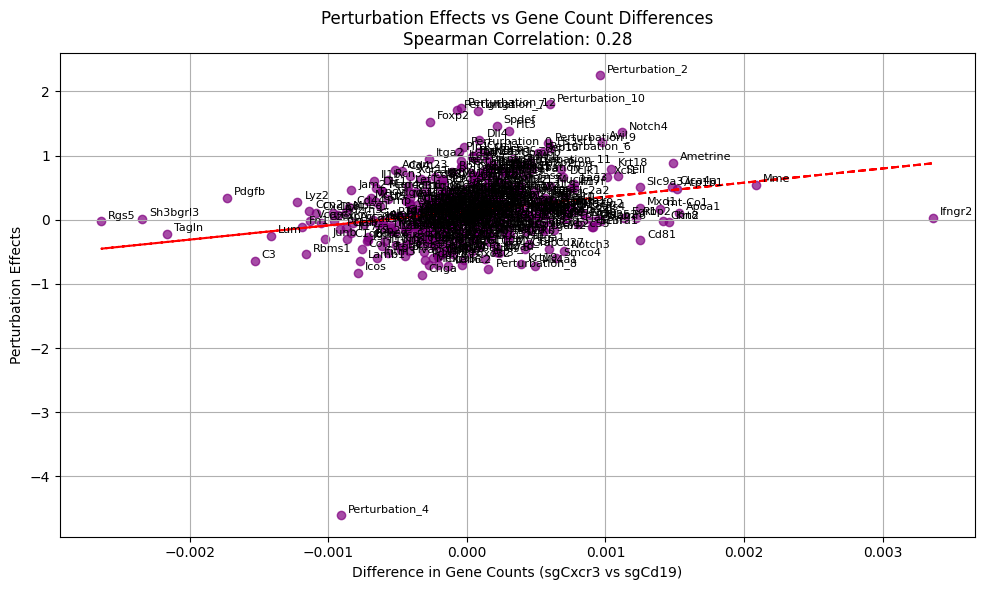

In [26]:

from scipy.stats import spearmanr
import numpy as np

perturbation_effects = effects_cells.loc['sgCxcr3'].values
# Calculate the difference in gene counts between the two batches
batch1_counts = query_adata[query_adata.obs['guide_rnas'] == 'sgCxcr3'].layers['resolvi_expression'].mean(axis=0)
batch2_counts = query_adata[query_adata.obs['guide_rnas'] == 'sgCd19'].layers['resolvi_expression'].mean(axis=0)
gene_count_diff = batch1_counts - batch2_counts

# Filter perturbation effects where values are less than 0.05
valid_indices = np.abs(perturbation_effects) >= 0
gene_count_diff_filtered = gene_count_diff[valid_indices]
perturbation_effects_filtered = perturbation_effects[valid_indices]

# Get gene names for annotation
gene_names = query_adata.var.index.values if hasattr(query_adata.var, "index") else np.arange(len(perturbation_effects))
gene_names_filtered = gene_names[valid_indices]

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(gene_count_diff_filtered, perturbation_effects_filtered)

# Plot the perturbation effects against the gene count differences
plt.figure(figsize=(10, 6))
plt.scatter(gene_count_diff_filtered, perturbation_effects_filtered, color='purple', alpha=0.7)

# Annotate each point with the gene name
for i, gene_name in enumerate(gene_names_filtered):
    plt.annotate(gene_name,
                 (gene_count_diff_filtered[i], perturbation_effects_filtered[i]),
                 textcoords="offset points", xytext=(5,2), ha='left', fontsize=8, color='black')

# Add line of best fit
m, b = np.polyfit(gene_count_diff_filtered, perturbation_effects_filtered, 1)
plt.plot(gene_count_diff_filtered, m * gene_count_diff_filtered + b, color='red', linestyle='--')

plt.xlabel('Difference in Gene Counts (sgCxcr3 vs sgCd19)')
plt.ylabel('Perturbation Effects')
plt.title(f'Perturbation Effects vs Gene Count Differences\nSpearman Correlation: {spearman_corr:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

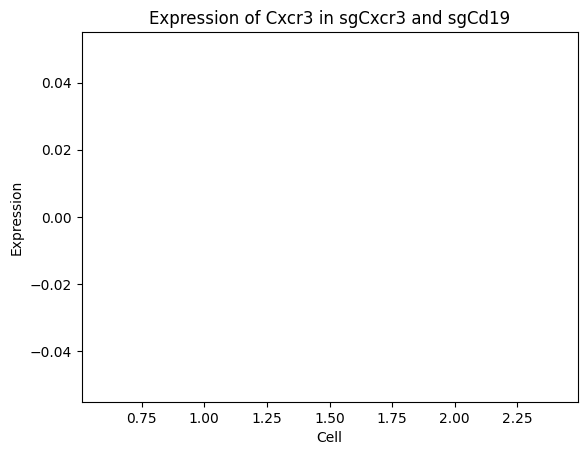

In [29]:
gene = 'Perturbation_2'
sgCxcr3 = query_adata[query_adata.obs['guide_rnas'] == 'sgCxcr3']
sgCd19 = query_adata[query_adata.obs['guide_rnas'] == 'sgCd19']

#bar graph of specific gene
index_gene = query_adata.var.index == gene

plt.bar(1,np.mean(sgCd19.X[:, index_gene]))
plt.bar(2,np.mean(sgCxcr3.X[:, index_gene]))
plt.xlabel('Cell')
plt.ylabel('Expression')
plt.title('Expression of Cxcr3 in sgCxcr3 and sgCd19')
plt.show()

In [16]:
from statsmodels.stats.multitest import multipletests

# Apply multiple testing correction
def correct_pvalues(pval_df, method='fdr_bh'):
    """Apply multiple testing correction to p-values DataFrame, removing rows with any NaN p-values."""
    # Remove rows with any NaN p-values
    pval_df_clean = pval_df[~pval_df.isna().any(axis=1)].copy()
    # Flatten p-values while keeping track of structure
    pval_flat = pval_df_clean.values.flatten()
    
    # Apply correction
    rejected, pval_corrected, alpha_sidak, alpha_bonf = multipletests(
        pval_flat, method=method, alpha=0.05
    )
    
    # Reshape back to original structure
    pval_corrected_df = pd.DataFrame(
        pval_corrected.reshape(pval_df_clean.shape),
        index=pval_df_clean.index,
        columns=pval_df_clean.columns
    )
    
    significant_df = pd.DataFrame(
        rejected.reshape(pval_df_clean.shape),
        index=pval_df_clean.index, 
        columns=pval_df_clean.columns
    )
    
    return pval_corrected_df, significant_df

# Apply different correction methods
pval_fdr, sig_fdr = correct_pvalues(pvalues, method='fdr_bh')        # Benjamini-Hochberg (recommended)

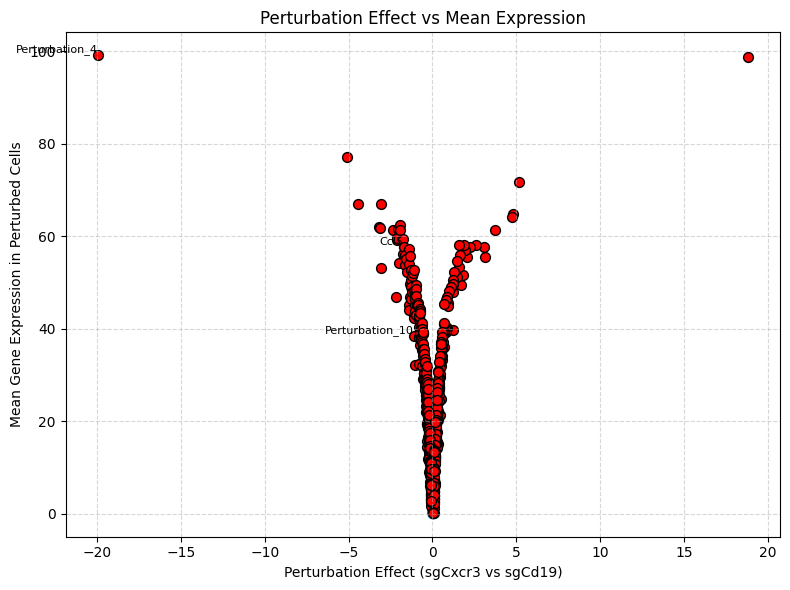

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

effects_list = effects.loc['sgCcl5'].values
prob_positive_list = -1*np.log10(pval_fdr.loc['sgCcl5'].values)
# max_prob_pos_prob_neg = np.stack([prob_positive_list, prob_negative_list], axis=1)
# prob_positive_list = np.max(max_prob_pos_prob_neg, axis=1)

# build a DataFrame
df = pd.DataFrame({
    'gene': query_adata.var.index.values if hasattr(query_adata.var, "index") else np.arange(len(effects_list)),
    'effect': effects_list,
    'mean_expr': prob_positive_list
})

# --- 2) Select top N by absolute effect for annotation ---
N = 400
topN = df.iloc[np.argsort(np.abs(df['effect']))[::-1][:N]]

# always include your genes of special interest
for g in ['Cxcr3','Perturbation_4','Perturbation_10']:
    if g in df['gene'].values:
        topN = pd.concat([topN, df[df['gene']==g]])
topN = topN.drop_duplicates('gene')

# --- 3) Plot volcano‐style scatter: effect vs mean expression ---
plt.figure(figsize=(8,6))
plt.scatter(df['effect'], df['mean_expr'], alpha=0.6)

# highlight the top hits
plt.scatter(topN['effect'], topN['mean_expr'], color='red', edgecolor='k', s=50)

# annotate
for _, row in topN.iterrows():
    if row['gene'] in ['Ccl5','Perturbation_4','Perturbation_10']:
        plt.text(row['effect'], row['mean_expr'], row['gene'],
                fontsize=8,
                ha='right' if row['effect']<0 else 'left',
                va='bottom')

plt.xlabel('Perturbation Effect (sgCxcr3 vs sgCd19)')
plt.ylabel('Mean Gene Expression in Perturbed Cells')
plt.title('Perturbation Effect vs Mean Expression')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [10]:


# 4. Get uncertainty estimates (multiple samples)
effects_with_uncertainty = supervised_resolvi.get_perturbation_effects(
    n_samples=100,
    return_mean=False  # Returns (n_samples, n_perturbations, n_genes)
)

# Calculate mean and standard deviation
effects_mean = effects_with_uncertainty.mean(axis=0)
effects_std = effects_with_uncertainty.std(axis=0)

# 5. Return as numpy array instead of DataFrame
effects_numpy = supervised_resolvi.get_perturbation_effects(
    return_numpy=True
)

In [ ]:
cell_indices = np.where(query_adata.obs['guide_rnas'] == 'sgCd19')[0]
effects_cells = supervised_resolvi.get_perturbation_effects(
    indices=cell_indices,
    n_samples=50,
    preserve_cell_heterogeneity=True,  # Enable new approach
    cell_summary_fn="median",           # Robust to outliers
    return_uncertainty=True,
    uncertainty_metrics=["std", "ci_95", "prob_significant"]
)

Processing 4 batches (≈14 perturbations × 50 samples each):   0%|          | 0/4 [00:00<?, ?it/s]

Batch 1/4: Running 13 perturbations (50 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Batch 2/4: Running 13 perturbations (50 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Batch 3/4: Running 13 perturbations (50 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Batch 4/4: Running 13 perturbations (50 samples each):   0%|          | 0/13 [00:00<?, ?it/s]

Computing uncertainty metrics (3 metrics for 13 perturbations × 480 genes):   0%|          | 0/3 [00:00<?, ?it…


perturbation_1 - Top upregulated genes:
Olfm4      0.160932
S100a4     0.146479
Cd74       0.140134
Il17a      0.136326
Lgr5       0.132411
Jchain     0.131299
Meg3       0.128033
Neurog3    0.125850
Mzb1       0.125348
Scn7a      0.124500
Name: perturbation_1, dtype: float32

perturbation_1 - Top downregulated genes:
Muc13    -0.125823
mt-Co1   -0.117608
Rbp2     -0.101208
Fabp2    -0.093622
Apoa1    -0.074589
Slc9a3   -0.073016
Ifngr1   -0.072394
Il18     -0.068574
Pcsk5    -0.060879
Ifngr2   -0.060798
Name: perturbation_1, dtype: float32

perturbation_2 - Top upregulated genes:
Upp1      0.180055
Cd74      0.155298
H2-Aa     0.086877
Itga6     0.075242
Ccl20     0.074872
Cd8b1     0.061757
Irf8      0.057358
H2-Eb1    0.054356
Il1a      0.053360
Atp1b1    0.047624
Name: perturbation_2, dtype: float32

perturbation_2 - Top downregulated genes:
Tyrobp   -0.097767
Muc13    -0.093395
C1qb     -0.084836
Csf1r    -0.083398
C1qa     -0.076835
Il2rg    -0.075518
Pecam1   -0.072680
Acta2   

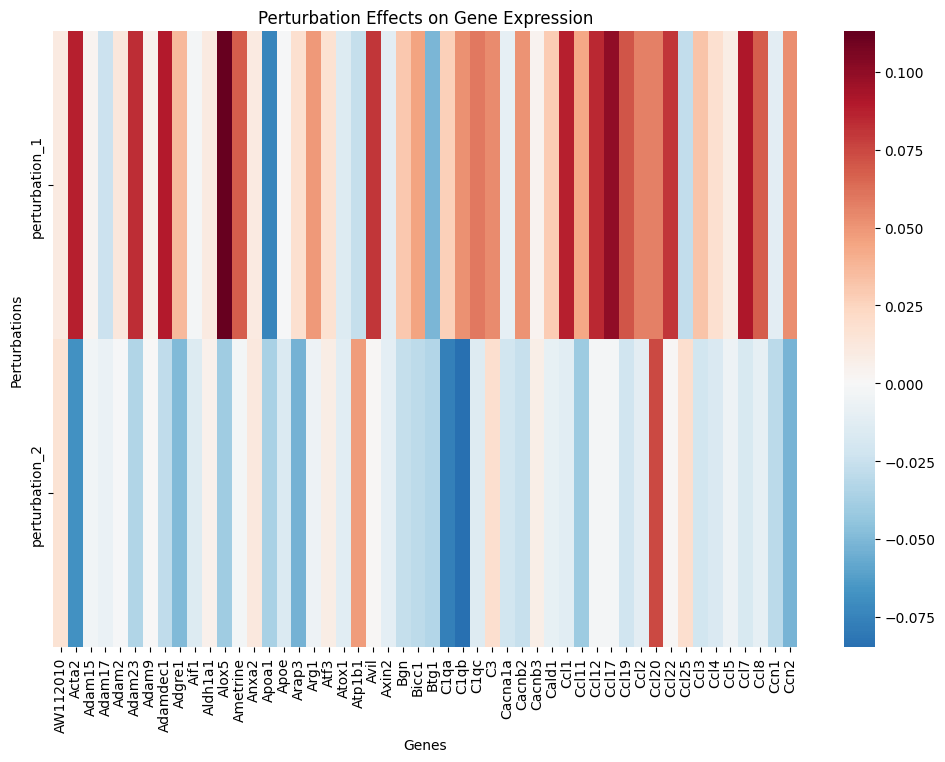

In [9]:
# Extract effects
effects_df = supervised_resolvi.get_perturbation_effects()

# Find genes most affected by each perturbation
for perturbation in effects_df.index:
    # Get top 10 upregulated genes
    top_up = effects_df.loc[perturbation].nlargest(10)
    print(f"\n{perturbation} - Top upregulated genes:")
    print(top_up)
    
    # Get top 10 downregulated genes  
    top_down = effects_df.loc[perturbation].nsmallest(10)
    print(f"\n{perturbation} - Top downregulated genes:")
    print(top_down)

# Visualize effects
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of perturbation effects
plt.figure(figsize=(12, 8))
sns.heatmap(effects_df.iloc[:, :50], cmap='RdBu_r', center=0)  # First 50 genes
plt.title('Perturbation Effects on Gene Expression')
plt.xlabel('Genes')
plt.ylabel('Perturbations')
plt.show()
